# Analysez les ventes d'une librairie avec Python

# Sommaire :
 - <a href="#C1">1. Importation des données</a>
 
 - <a href="#C2">2. Nettoyer le jeu de données</a>
 
 
 - <a href="#C3">3. Un zoom sur les références, les tops et les flops, la répartition par catégorie, etc</a>
 - <a href="#C4">4. Différents indicateurs et graphiques autour du CA</a>
 - <a href="#C5">5. L’évolution dans le temps - moyenne mobile </a>
 - <a href="#C6">6. Quelques informations sur les profils de nos clients </a>
 - <a href="#C7">7. La répartition du chiffre d'affaires entre les clients : une courbe de Lorenz - l'indice de GINI </a>
 
 
 - <a href="#C8">8. Le lien entre l’âge des clients et la fréquence d’achat </a>
 
 - <a href="#C9">9. Le lien entre l’âge des clients et le montant total des achats </a>
 - <a href="#C10">10. Le lien entre l’âge des clients et les catégories des livres achetés - ANOVA - Test de Levene - Le test de Kruskal-Wallis</a>
 - <a href="#C11">11. Le lien entre l'âge des clients et la taille moyenne du panier </a>
 - <a href="#C12">12. Le lien entre le genre d’un client et les catégories des livres achetés - Chi2</a>

## <a name="C1">1. Importation des données</a>

Importons dans un premier temps l'ensemble des librairies qui vont nous servir durant l'entièreté de ce projet :

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly as plt
import datetime as dt
import matplotlib.pyplot as  plt
import plotly.graph_objs as go
import scipy.stats as stats

Nous pouvons à présent charger le jeu de données. 

In [2]:
customers = pd.read_csv('customers.csv')
products = pd.read_csv('products.csv')
transactions = pd.read_csv('transactions.csv')

 ### Customers

In [3]:
customers.head()

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


In [4]:
customers.describe()

,birth
count,8623.000000
mean,1978.280877
std,16.919535
min,1929.000000
25%,1966.000000
50%,1979.000000
75%,1992.000000
max,2004.000000


In [5]:
customers.client_id.nunique()

8623

In [6]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8623 non-null   object
 1   sex        8623 non-null   object
 2   birth      8623 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 202.2+ KB


### Products

In [7]:
products.head()

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


In [8]:
products.describe()

,price,categ
count,3287.000000,3287.000000
mean,21.856641,0.370246
std,29.847908,0.615387
min,-1.000000,0.000000
25%,6.990000,0.000000
50%,13.060000,0.000000
75%,22.990000,1.000000
max,300.000000,2.000000


In [9]:
products.id_prod.nunique()

3287

In [10]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3287 non-null   object 
 1   price    3287 non-null   float64
 2   categ    3287 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.2+ KB


### Transactions

In [11]:
transactions.head()

,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232


In [12]:
transactions.describe()

,id_prod,date,session_id,client_id
count,679532,679532,679532,679532
unique,3267,679371,342316,8602
top,1_369,test_2021-03-01 02:30:02.237413,s_0,c_1609
freq,2252,13,200,25488


In [13]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679532 entries, 0 to 679531
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     679532 non-null  object
 1   date        679532 non-null  object
 2   session_id  679532 non-null  object
 3   client_id   679532 non-null  object
dtypes: object(4)
memory usage: 20.7+ MB


In [14]:
products[products['price']==-1]

,id_prod,price,categ
731,T_0,-1.0,0


# <a name="C2">2. Nettoyer le jeu de données</a>

### Vérifier correspondance des lignes qui contient TEST  avec id_pro == T_0

In [15]:
transactions[transactions.date.str.contains('test')].id_prod.value_counts()

T_0    200
Name: id_prod, dtype: int64

### Créer le dataframe de "transactions_mod" et supprimer 200 lignes de date qui contient TEST

In [16]:
transactions_mod=transactions[transactions.date.str.contains('test')==False].copy()
transactions_mod

,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232
...,...,...,...,...
679527,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489
679528,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370
679529,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304
679530,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227


### Changer la format de date

In [17]:
transactions_mod['date'] = pd.to_datetime(transactions_mod['date'])

### Afficher les info de transactions_mod

In [18]:
transactions_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679332 entries, 0 to 679531
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     679332 non-null  object        
 1   date        679332 non-null  datetime64[ns]
 2   session_id  679332 non-null  object        
 3   client_id   679332 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 25.9+ MB


### Merger "transactions_mod" avec "products"

In [19]:
trans_prod=pd.merge(transactions_mod, products, on='id_prod',how='outer', indicator=True)

In [20]:
trans_prod

,id_prod,date,session_id,client_id,price,categ,_merge
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,4.18,0.0,both
1,0_1518,2021-09-26 12:37:29.780414,s_95811,c_6197,4.18,0.0,both
2,0_1518,2021-05-06 17:14:43.117440,s_30782,c_682,4.18,0.0,both
3,0_1518,2022-03-16 18:57:10.420103,s_180057,c_5932,4.18,0.0,both
4,0_1518,2022-11-12 18:58:10.574853,s_296584,c_7217,4.18,0.0,both
...,...,...,...,...,...,...,...
679349,0_1624,NaT,NaN,NaN,24.50,0.0,right_only
679350,2_86,NaT,NaN,NaN,132.36,2.0,right_only
679351,0_299,NaT,NaN,NaN,22.99,0.0,right_only
679352,0_510,NaT,NaN,NaN,23.66,0.0,right_only


### Afficher _merge

In [21]:
trans_prod._merge.value_counts()

both          679111
left_only        221
right_only        22
Name: _merge, dtype: int64

### Afficher left_only dans la  _merge

In [22]:
trans_prod[trans_prod['_merge']=='left_only']

,id_prod,date,session_id,client_id,price,categ,_merge
542560,0_2245,2022-09-23 07:22:38.636773,s_272266,c_4746,NaN,NaN,left_only
542561,0_2245,2022-07-23 09:24:14.133889,s_242482,c_6713,NaN,NaN,left_only
542562,0_2245,2022-12-03 03:26:35.696673,s_306338,c_5108,NaN,NaN,left_only
542563,0_2245,2021-08-16 11:33:25.481411,s_76493,c_1391,NaN,NaN,left_only
542564,0_2245,2022-07-16 05:53:01.627491,s_239078,c_7954,NaN,NaN,left_only
...,...,...,...,...,...,...,...
542776,0_2245,2021-08-25 09:06:03.504061,s_80395,c_131,NaN,NaN,left_only
542777,0_2245,2022-03-06 19:59:19.462288,s_175311,c_4167,NaN,NaN,left_only
542778,0_2245,2022-05-16 11:35:20.319501,s_209381,c_4453,NaN,NaN,left_only
542779,0_2245,2022-02-11 09:05:43.952857,s_163405,c_1098,NaN,NaN,left_only


In [23]:
trans_prod[trans_prod['_merge']=='left_only'].id_prod.value_counts()

0_2245    221
Name: id_prod, dtype: int64

# <a name="C3">3. Un zoom sur les références, les tops et les flops, la répartition par catégorie, etc. </a>


### Afficher boxplot de price par categ

<AxesSubplot:xlabel='categ', ylabel='price'>

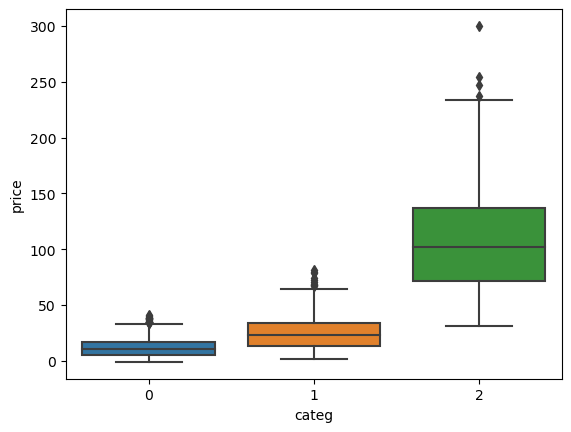

In [24]:
sns.boxplot(data=products, x='categ', y='price')

### La moyenne de price par categ

In [25]:
products.groupby(by='categ')[["price"]].mean()

,price
categ,
0,11.727280
1,25.531421
2,108.354686


### Remplacer le price par 11.727280 (la moyenne de categ 0)

In [26]:
trans_prod.price.fillna(11.727280, inplace=True)
trans_prod[trans_prod['_merge']=='left_only']

,id_prod,date,session_id,client_id,price,categ,_merge
542560,0_2245,2022-09-23 07:22:38.636773,s_272266,c_4746,11.72728,NaN,left_only
542561,0_2245,2022-07-23 09:24:14.133889,s_242482,c_6713,11.72728,NaN,left_only
542562,0_2245,2022-12-03 03:26:35.696673,s_306338,c_5108,11.72728,NaN,left_only
542563,0_2245,2021-08-16 11:33:25.481411,s_76493,c_1391,11.72728,NaN,left_only
542564,0_2245,2022-07-16 05:53:01.627491,s_239078,c_7954,11.72728,NaN,left_only
...,...,...,...,...,...,...,...
542776,0_2245,2021-08-25 09:06:03.504061,s_80395,c_131,11.72728,NaN,left_only
542777,0_2245,2022-03-06 19:59:19.462288,s_175311,c_4167,11.72728,NaN,left_only
542778,0_2245,2022-05-16 11:35:20.319501,s_209381,c_4453,11.72728,NaN,left_only
542779,0_2245,2022-02-11 09:05:43.952857,s_163405,c_1098,11.72728,NaN,left_only


### Imputer le colonne de categ

In [27]:
trans_prod.categ.fillna(0, inplace=True)
trans_prod[trans_prod['_merge']=='left_only']

,id_prod,date,session_id,client_id,price,categ,_merge
542560,0_2245,2022-09-23 07:22:38.636773,s_272266,c_4746,11.72728,0.0,left_only
542561,0_2245,2022-07-23 09:24:14.133889,s_242482,c_6713,11.72728,0.0,left_only
542562,0_2245,2022-12-03 03:26:35.696673,s_306338,c_5108,11.72728,0.0,left_only
542563,0_2245,2021-08-16 11:33:25.481411,s_76493,c_1391,11.72728,0.0,left_only
542564,0_2245,2022-07-16 05:53:01.627491,s_239078,c_7954,11.72728,0.0,left_only
...,...,...,...,...,...,...,...
542776,0_2245,2021-08-25 09:06:03.504061,s_80395,c_131,11.72728,0.0,left_only
542777,0_2245,2022-03-06 19:59:19.462288,s_175311,c_4167,11.72728,0.0,left_only
542778,0_2245,2022-05-16 11:35:20.319501,s_209381,c_4453,11.72728,0.0,left_only
542779,0_2245,2022-02-11 09:05:43.952857,s_163405,c_1098,11.72728,0.0,left_only


In [28]:
trans_prod[trans_prod['_merge']=='right_only'].index

Int64Index([679332, 679333, 679334, 679335, 679336, 679337, 679338, 679339,
            679340, 679341, 679342, 679343, 679344, 679345, 679346, 679347,
            679348, 679349, 679350, 679351, 679352, 679353],
           dtype='int64')

### Supprimer les right_only

In [29]:
trans_prod.drop(trans_prod[trans_prod['_merge']=='right_only'].index,axis=0, inplace=True)

In [30]:
trans_prod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679332 entries, 0 to 679331
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     679332 non-null  object        
 1   date        679332 non-null  datetime64[ns]
 2   session_id  679332 non-null  object        
 3   client_id   679332 non-null  object        
 4   price       679332 non-null  float64       
 5   categ       679332 non-null  float64       
 6   _merge      679332 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(2), object(3)
memory usage: 36.9+ MB


In [31]:
trans_prod._merge.value_counts()

both          679111
left_only        221
right_only         0
Name: _merge, dtype: int64

### Supprimer _merge

In [32]:
trans_prod.drop('_merge', axis=1, inplace=True)

### Afficher les doublonns

In [33]:
trans_prod.duplicated().sum()

0

In [34]:
trans_prod.date.nunique()

679332

### Merger trans_prod avec customers

In [35]:
trans_prod_cli=pd.merge(trans_prod,customers, on='client_id', how='outer', indicator=True)
trans_prod_cli

,id_prod,date,session_id,client_id,price,categ,sex,birth,_merge
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,4.18,0.0,f,1986,both
1,0_1518,2021-07-20 13:21:29.043970,s_64849,c_103,4.18,0.0,f,1986,both
2,0_1518,2022-08-20 13:21:29.043970,s_255965,c_103,4.18,0.0,f,1986,both
3,0_1418,2022-06-18 01:49:37.823274,s_225411,c_103,8.57,0.0,f,1986,both
4,0_1418,2021-08-18 01:49:37.823274,s_77214,c_103,8.57,0.0,f,1986,both
...,...,...,...,...,...,...,...,...,...
679350,NaN,NaT,NaN,c_7584,NaN,NaN,f,1960,right_only
679351,NaN,NaT,NaN,c_90,NaN,NaN,m,2001,right_only
679352,NaN,NaT,NaN,c_587,NaN,NaN,m,1993,right_only
679353,NaN,NaT,NaN,ct_1,NaN,NaN,m,2001,right_only


### Afficher le _merge

In [36]:
trans_prod_cli._merge.value_counts()

both          679332
right_only        23
left_only          0
Name: _merge, dtype: int64

In [37]:
trans_prod_cli.drop(trans_prod_cli[trans_prod_cli['_merge']=='right_only'].index,axis=0, inplace=True)

In [38]:
trans_prod_cli._merge.value_counts()

both          679332
left_only          0
right_only         0
Name: _merge, dtype: int64

### Supprimer _merge, right_only dans la table de trans_prod_cli

In [39]:
trans_prod_cli.drop('_merge', axis=1, inplace=True)

### Afficher les infos dans la table de trans_prod_cli

In [40]:
trans_prod_cli.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679332 entries, 0 to 679331
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     679332 non-null  object        
 1   date        679332 non-null  datetime64[ns]
 2   session_id  679332 non-null  object        
 3   client_id   679332 non-null  object        
 4   price       679332 non-null  float64       
 5   categ       679332 non-null  float64       
 6   sex         679332 non-null  object        
 7   birth       679332 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 46.6+ MB


# <a name="C4">4. Différents indicateurs et graphiques autour du CA </a>

### CA par client

In [41]:
CA_Client= trans_prod_cli.groupby(by='client_id')[["price"]].sum()
CA_Client.sort_values(by='price', ascending=False).head(10)

,price
client_id,
c_1609,324033.35000
c_4958,289760.34000
c_6714,153669.28368
c_3454,113673.11184
c_3263,5276.87000
c_1570,5271.62000
c_2899,5214.05000
c_2140,5208.82000
c_7319,5155.77000


In [42]:
dep = CA_Client.price.values
dep

array([ 558.18, 1353.6 ,  254.85, ..., 1490.01, 2779.88,  701.4 ])

### CA par produit

In [43]:
CA_Prod=trans_prod_cli.groupby(by='id_prod')[["price"]].sum()
CA_Prod.head()

,price
id_prod,
0_0,4657.50
0_1,5352.13
0_10,394.90
0_100,61.80
0_1000,2954.88


### CA mensuel par produit

In [44]:
CA_Mens=trans_prod_cli[['date','price']].set_index("date").resample("M").sum()
CA_Mens.head()

,price
date,
2021-03-31,482546.15552
2021-04-30,476273.48192
2021-05-31,493037.28824
2021-06-30,484170.65096
2021-07-31,482882.30912


   ### Visualier le CA mensuel 

<AxesSubplot:xlabel='date', ylabel='price'>

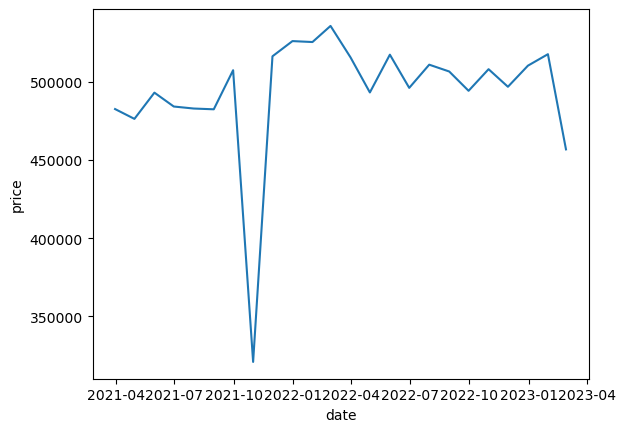

In [45]:
sns.lineplot(data=CA_Mens, x='date', y='price')

### 

### Agréger  "date", "categ" et "price" par date (mensuellement) et categ

In [46]:
CAdc = trans_prod_cli[['categ','date','price']].groupby([pd.Grouper(key='date', freq='M'), 'categ']).sum()
CAdc.head(9)

price
date       categ              
2021-03-31 0.0    193734.71552
           1.0    186974.17000
           2.0    101837.27000
2021-04-30 0.0    205386.64192
           1.0    156138.35000
           2.0    114748.49000
2021-05-31 0.0    196280.53824
           1.0    165893.40000
           2.0    130863.35000

   ### Visualiser le CA par catégorie

<AxesSubplot:xlabel='date', ylabel='price'>

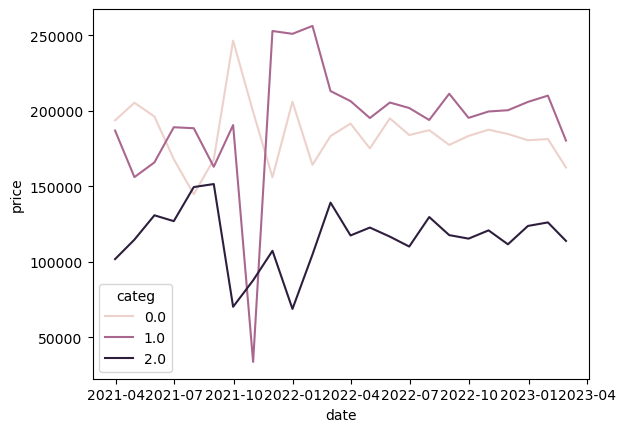

In [47]:
sns.lineplot(data=CAdc, x='date', y='price', hue='categ')

## <a name="C5">5. L’évolution dans le temps - moyenne mobile</a>

### Afficher la moyenne mobile de CA mensuel

In [48]:
CA_MM=CA_Mens.rolling(3).mean()
CA_MM.head(10)

,price
date,
2021-03-31,NaN
2021-04-30,NaN
2021-05-31,483952.308560
2021-06-30,484493.807040
2021-07-31,486696.749440
2021-08-31,483147.765200
2021-09-30,490884.684000
2021-10-31,436884.191280
2021-11-30,448182.413707


### Visualiser le CA mensuel

<AxesSubplot:xlabel='date', ylabel='price'>

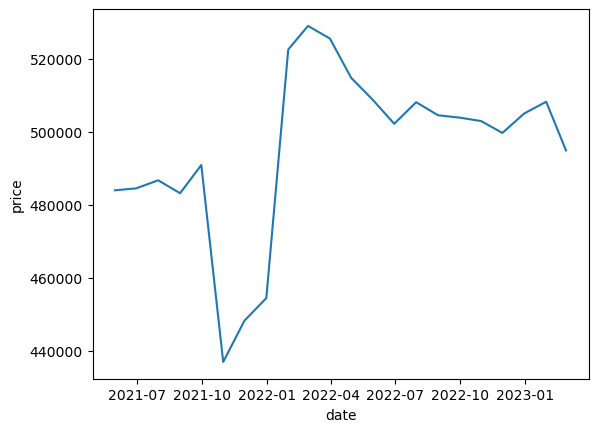

In [49]:
sns.lineplot(data=CA_MM, x='date', y='price')

Le CA s'évolue par rapport la saison, nous pouvons voir que pendant l'été le CA baisse et courant l'hiver il augmente. Par conséquent nous pouvons constater la notion de saisonnalité. 

# <a name="C6">6. Quelques Informations sur les profils de nos clients </a> 

In [50]:
bins = [0, 20, 40, 60, 80, np.inf]
names = ['<21', '21-40', '41-60', '61-80', '81+']


In [51]:
# ajouter le colonne d'age dans la table de trans_prod_cli
trans_prod_cli['age']=2023-trans_prod_cli['birth']
trans_prod_cli

,id_prod,date,session_id,client_id,price,categ,sex,birth,age
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,4.18,0.0,f,1986,37
1,0_1518,2021-07-20 13:21:29.043970,s_64849,c_103,4.18,0.0,f,1986,37
2,0_1518,2022-08-20 13:21:29.043970,s_255965,c_103,4.18,0.0,f,1986,37
3,0_1418,2022-06-18 01:49:37.823274,s_225411,c_103,8.57,0.0,f,1986,37
4,0_1418,2021-08-18 01:49:37.823274,s_77214,c_103,8.57,0.0,f,1986,37
...,...,...,...,...,...,...,...,...,...
679327,2_147,2021-07-23 07:01:38.963669,s_65994,c_4391,181.99,2.0,f,2001,22
679328,0_142,2022-03-25 18:07:25.880052,s_184472,c_1232,19.85,0.0,f,1960,63
679329,0_142,2021-09-25 18:07:25.880052,s_95415,c_1232,19.85,0.0,f,1960,63
679330,2_205,2021-03-11 00:11:32.016264,s_4605,c_7534,100.99,2.0,m,1992,31


### Ajouter le colonne d'age

In [52]:
trans_prod_cli['AgeRange'] = pd.cut(trans_prod_cli['age'], bins, labels=names)
trans_prod_cli.AgeRange.value_counts()

41-60    333686
21-40    235965
61-80     78478
<21       19520
81+       11683
Name: AgeRange, dtype: int64

### Calculer  CA par tranche d'age

In [53]:
CA_TrancheAge=trans_prod_cli[['AgeRange','price']].groupby(by='AgeRange').sum('price')
CA_TrancheAge

,price
AgeRange,
<21,7.872095e+05
21-40,4.830435e+06
41-60,4.727929e+06
61-80,1.314293e+06
81+,1.964542e+05


([<matplotlib.patches.Wedge at 0x28882b37f70>,
 [Text(1.0761566101350957, 0.2277870726414033, '<21'),
  Text(-0.13857228934183147, 1.0912367848576972, '21-40'),
  Text(-0.5104764050221666, -0.9743786943050659, '41-60'),
  Text(0.9893594825041186, -0.48079914140853336, '61-80'),
  Text(1.0985099719633873, -0.05723496743248879, '81+')],
 [Text(0.586994514619143, 0.12424749416803815, '7%'),
  Text(-0.07558488509554444, 0.5952200644678347, '41%'),
  Text(-0.2784416754666363, -0.5314792878027631, '40%'),
  Text(0.5396506268204283, -0.2622540771319273, '11%'),
  Text(0.5991872574345748, -0.031219073144993885, '2%')])

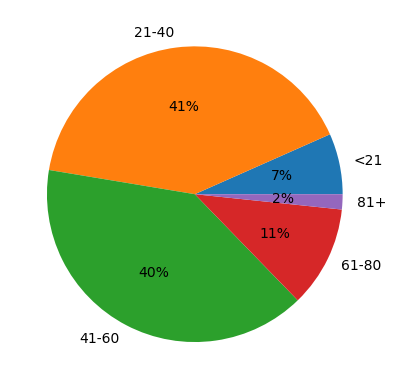

In [54]:
plt.pie(data=CA_TrancheAge, x="price", labels=CA_TrancheAge.index,  autopct='%.0f%%')

81% de CA est réalisé par les clients âge entre 21 et 60 ans

### CA par sexe

In [55]:
CA_sex=trans_prod_cli[['sex','price']].groupby(by='sex').sum('price')
CA_sex

,price
sex,
f,5.861055e+06
m,5.995265e+06


([<matplotlib.patches.Wedge at 0x28882e03d30>,
 [Text(0.019558001527555827, 1.0998261156093032, 'f'),
  Text(-0.019557898554403392, -1.0998261174404507, 'm')],
 [Text(0.010668000833212269, 0.5999051539687107, '49%'),
  Text(-0.010667944666038213, -0.5999051549675184, '51%')])

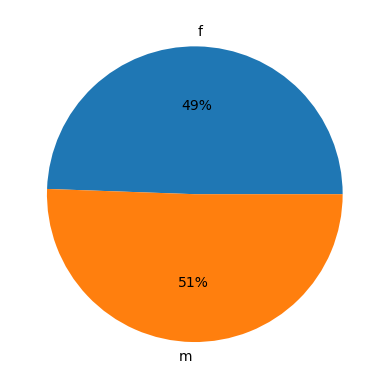

In [56]:
plt.pie(data=CA_sex, x="price", labels=CA_sex.index,  autopct='%.0f%%')

# <a name="C7">7. La répartition du chiffre d'affaires entre les clients : une courbe de Lorenz</a> 

### Inégalités de CA entre tous les clients

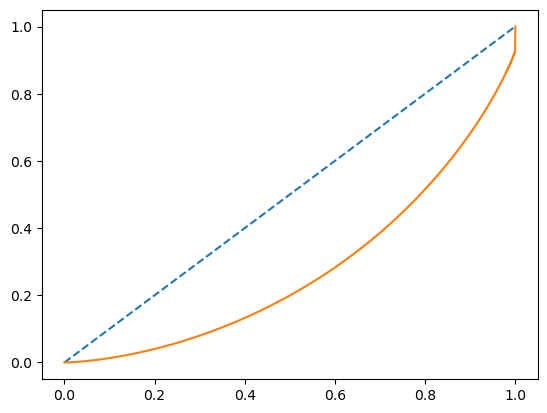

In [57]:
dep =CA_Client.price.values
n = len(dep)

lorenz = np.cumsum(np.sort(dep)) / dep.sum()
lorenz = np.append([0],lorenz) 
xaxis = np.linspace(0-1/n,1+1/n,n+1) 

plt.plot(xaxis,xaxis, "--")
plt.plot(xaxis,lorenz,drawstyle='steps-post')
plt.show()


### Calculer l'indice de GINI

L'indice de Gini mesure ici l'inégalité des chiffres d'affaires de tous les clients.

Indice de Gini : chiffre de 0 à 1 mesurant l'aire entre la bissectrice et la courbe de Lorenz

un coefficient de 0 indiquerait une égalité parfaite (tous les points s'aligneraient alors sur la bissectrice, réduisant l'aire à 0)
si l'indice était de 1, un seul client détiendrait la totalité du chiffre d'affaires (l'aire serait égale à celle du triangle prenant la bissectrice comme côté et 1:1 comme angle opposé)

In [58]:
AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
gini = 2*S
gini

0.44639658303540086

## <a name="C8">8. Le lien entre l’âge des clients et la fréquence d’achat</a>

In [59]:
# Frequence d'achat vs age
client_session=trans_prod_cli[['client_id','session_id']].drop_duplicates()
freq_achat = client_session.groupby(by='client_id').count()
age_freq = customers[['client_id','birth']].merge(freq_achat, on='client_id',how='inner')
age_freq['age']=2023-age_freq['birth']
age_freq

,client_id,birth,session_id,age
0,c_4410,1967,52,56
1,c_7839,1975,19,48
2,c_1699,1984,6,39
3,c_5961,1962,58,61
4,c_5320,1943,18,80
...,...,...,...,...
8595,c_7920,1956,47,67
8596,c_7403,1970,123,53
8597,c_5119,1974,25,49
8598,c_5643,1968,95,55


### Afficher les session_ids inferieur à 2000 ( exclure les outliers)

In [60]:
age_freq=age_freq[age_freq['session_id']<2000]

<AxesSubplot:xlabel='age', ylabel='session_id'>

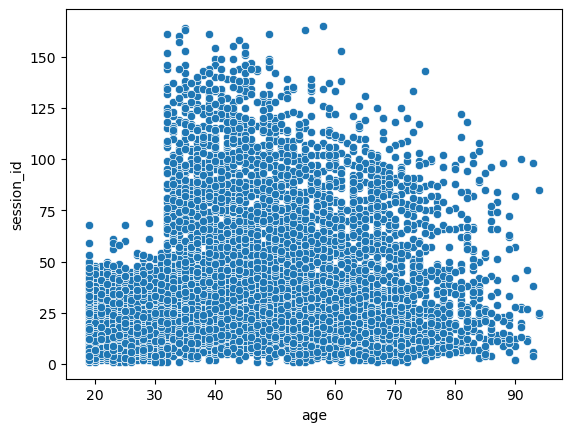

In [61]:
sns.scatterplot(data=age_freq,x='age',y='session_id')
#.xlabel("age")
#plt.ylabel("montant")


### Le Test de Normalité de Kolmogorov Smirnov
Le test de normalité de Kolmogorov-Smirnov permet de déterminer si une distribution généralement une distribution d’échantillon – correspond aux caractéristiques d’une distribution normale.

C’est prérequis pour toute utilisation d’un test statistique paramétrique.
Le Test de Normalité de Kolmogorov Smirnov est aussi adapté aux échelles normales. 
Si la statistique D est significative, nous devons rejeter l'hypothèse selon laquelle la distribution respective est normale.

le coefficient est significatif -> la valeur de p doit être plus petite que 0,05 

le coefficient est non significatif -> on considère qu'il est semblable à r = 0 

si c'était normal on fait le test Pearson sinon on fait le test Spearman

### tester la normalité de fréquence d'achat

In [62]:
y = age_freq['session_id']
D, p = stats.kstest(y,'norm')
print ("Kolmogorov-Smirnov: D:{0} p={1}". format(D,p))

Kolmogorov-Smirnov: D:0.987831116393684 p=0.0


### tester la normalité d'age

In [63]:
x = age_freq['age']
D, p = stats.kstest(x,'norm')
print ("Kolmogorov-Smirnov: D:{0} p={1}".format(D,p))

Kolmogorov-Smirnov: D:1.0 p=0.0


Les ages ne suivent pas une distribution Normale, le test est forcément non pramétrique, on utilise donc un test de corrélation de Spearman.

In [64]:
from scipy.stats import spearmanr
list1= age_freq['age']
list2 = age_freq['session_id']

corr, p = spearmanr(list1, list2)
print('spearman correlation: %.3f' % corr, 'pvalue=',p) 

spearman correlation: 0.212 pvalue= 3.180991037736119e-88


Les intérpretations des résultats des tests de spearman : 

Une valeur positive (maximum = +1) indique une variation simultanée dans le même sens, une valeur négative (minimum = -1) une variation simultanée en sens inverse.

Une valeur de 0 de 𝑟s indique qu’il n’y a pas de relation entre les variables. Plus la valeur de 𝑟s
est proche de −1 ou 1, plus la corrélation est forte ; et plus elle est proche de 0, plus la corrélation est faible.

Ici, le coefficient de corrélation lui-même est de 0,212. Cela indique une relation positive (depuis son nombre positif), ce qui indique que si l'un monte, l'autre monte probablement aussi. La corrélation est significative, puisque la valeur de p est bien inférieure au seuil habituel de 0,05. 

H0: le coefficeint de corrélation de Spearman est ègal à 0 -> aucune corrélation

H1: le coéfficient de corrélation de Spearman est différent de 0 -> il y a une corrélation

On rejette H0 si p-valeur < 0.05

Donc il y a une faible corrélation entre les age des clients et leurs frequences d'achats. 

## <a name="C9">9. Le lien entre l'âge des clients et montant total des achats </a>

In [65]:
# Montant d'achat vs age
mont = trans_prod_cli.groupby(by='client_id')[["price"]].sum()
age_mont = customers[["client_id","birth"]].merge(mont,on="client_id", how='inner')

age_mont.sort_values(by="price", ascending=False)

,client_id,birth,price
3633,c_1609,1980,324033.35000
1377,c_4958,1999,289760.34000
1910,c_6714,1968,153669.28368
8067,c_3454,1969,113673.11184
4713,c_3263,1985,5276.87000
...,...,...,...
1553,c_4648,2004,11.20000
6299,c_240,1998,11.06000
2462,c_8114,1962,9.98000
2717,c_8140,1971,8.30000


### Créer le colonne d'age

In [66]:
age_mont['age']=2023-age_mont['birth']
age_mont

,client_id,birth,price,age
0,c_4410,1967,1376.82,56
1,c_7839,1975,554.93,48
2,c_1699,1984,190.60,39
3,c_5961,1962,1150.42,61
4,c_5320,1943,396.53,80
...,...,...,...,...
8595,c_7920,1956,1897.16,67
8596,c_7403,1970,2592.73,53
8597,c_5119,1974,729.69,49
8598,c_5643,1968,1995.95,55


### tester la normalité de montant

In [67]:
x = age_mont['price']
D, p = stats.kstest(x,'norm')
print ("Kolmogorov-Smirnov: D:{0} p={1}".format(D,p))

Kolmogorov-Smirnov: D:0.9999999998604823 p=0.0


la valeur de P est inférieur à 0.05 donc le test ne suis pas la loi de normalité, par conséquent on fait le test de Spearman

### Filtrer les montant inférieur à 100000

In [68]:
age_mont=age_mont[age_mont['price']<100000]

### Afficher le montant total des achats selon l'âge des clients

<AxesSubplot:xlabel='age', ylabel='price'>

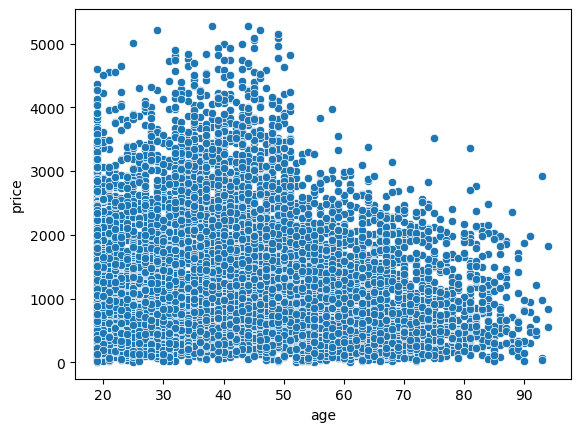

In [69]:
sns.scatterplot(data=age_mont,x='age',y='price')
#.xlabel("Age")
#plt.ylabel("Montant")

In [70]:
list1= age_mont['age']
list2 = age_mont['price']

corr, p = spearmanr(list1, list2)
print('Spearman correlation: %.3f' % corr, 'pvalue=',p) 

Spearman correlation: -0.185 pvalue= 4.0721226705181694e-67


Les intérpretations des résultats des tests de spearman :

Ici, le coefficient de corrélation lui-même est de -0.185. Cela indique une relation négatif (depuis son nombre négatif). La corrélation est significative, puisque la valeur de p est bien inférieure au seuil habituel de 0,05. 

H0: le coefficeint de corrélation de Spearman est ègal à 0 -> aucune corrélation 

H1: le coéfficient de corrélation de Spearman est différent de 0 -> il y a une corrélation

On rejette H0 si p-valeur < 0.05

Donc il y a une faible corrélation négativement entre les ages des clients et les montants totals des achats.

## <a name="C10">10. Le lien entre l'âge des clients et les catégories des livres achetés - ANOVA</a>

### Afficher boxplot pour correlation entre age et catégorie

<AxesSubplot:xlabel='categ', ylabel='age'>

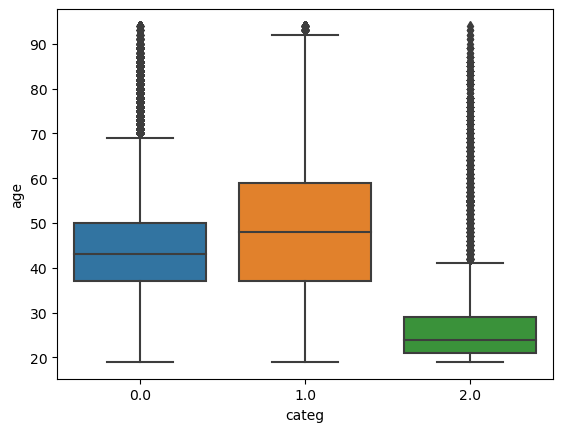

In [71]:
sns.boxplot(data=trans_prod_cli,x='categ',y='age')

### Categ_0

array([[<AxesSubplot:title={'center':'age'}>]], dtype=object)

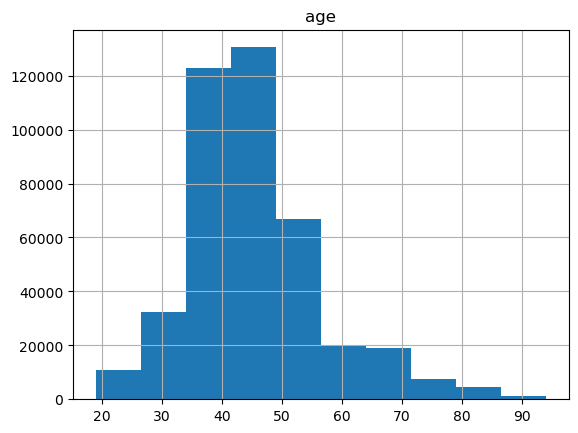

In [72]:
categ_0=trans_prod_cli[trans_prod_cli['categ']==0.0]
categ_0.hist('age')

In [73]:
# test la loi normal
shapiro_test0 = stats.shapiro(categ_0.age)
shapiro_test0

C:\Users\morta\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9367284774780273, pvalue=0.0)

In [74]:
categ_0

,id_prod,date,session_id,client_id,price,categ,sex,birth,age,AgeRange
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,4.18,0.0,f,1986,37,21-40
1,0_1518,2021-07-20 13:21:29.043970,s_64849,c_103,4.18,0.0,f,1986,37,21-40
2,0_1518,2022-08-20 13:21:29.043970,s_255965,c_103,4.18,0.0,f,1986,37,21-40
3,0_1418,2022-06-18 01:49:37.823274,s_225411,c_103,8.57,0.0,f,1986,37,21-40
4,0_1418,2021-08-18 01:49:37.823274,s_77214,c_103,8.57,0.0,f,1986,37,21-40
...,...,...,...,...,...,...,...,...,...,...
679302,0_1856,2022-12-13 23:00:11.780612,s_311618,c_674,9.57,0.0,m,1960,63,61-80
679303,0_1856,2021-11-13 23:00:11.780612,s_119245,c_674,9.57,0.0,m,1960,63,61-80
679323,0_1692,2021-09-15 19:42:08.596375,s_90430,c_4478,13.36,0.0,f,1970,53,41-60
679328,0_142,2022-03-25 18:07:25.880052,s_184472,c_1232,19.85,0.0,f,1960,63,61-80


### Categ_1

array([[<AxesSubplot:title={'center':'age'}>]], dtype=object)

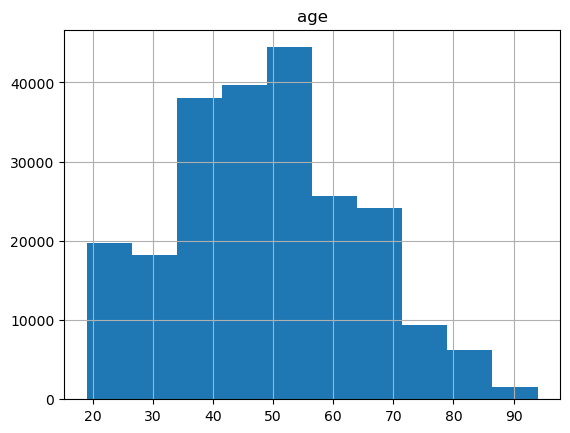

In [75]:
categ_1=trans_prod_cli[trans_prod_cli['categ']==1.0]
categ_1.hist('age')

In [76]:
# test la loi normal
shapiro_test1 = stats.shapiro(categ_1.age)
shapiro_test1

C:\Users\morta\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9893467426300049, pvalue=0.0)

### Categ_2_Histogram

array([[<AxesSubplot:title={'center':'age'}>]], dtype=object)

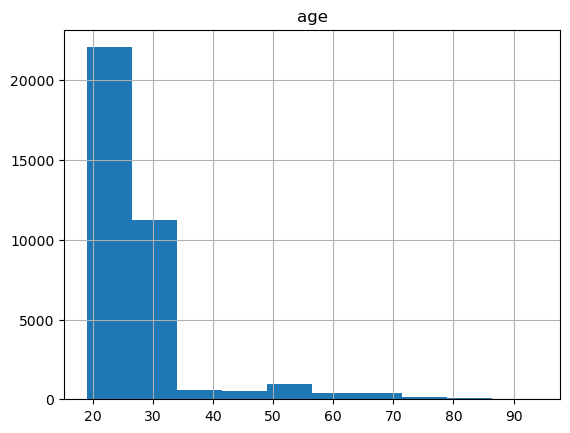

In [77]:
categ_2=trans_prod_cli[trans_prod_cli['categ']==2.0]
categ_2.hist('age')

In [78]:
# test la loi normal
shapiro_test2 = stats.shapiro(categ_2.age)
shapiro_test2

C:\Users\morta\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.6679463386535645, pvalue=0.0)

### On fait le test Levene pour 3 caégories

In [79]:
stat, p_value = stats.levene(categ_0.age, categ_1.age, categ_2.age)

print(f"Lavene's test statistic: {stat}")
print(f"P-value: {p_value}")

Lavene's test statistic: 26091.730839883512
P-value: 0.0


On rejet le H0, c est à dire que on ne peut pas faire l'ANOVA
donc il faut faire le test non-paramétirque /Kruskal-Wallis

### Le test de Kruskal-Wallis

Le test de Kruskal-Wallis est un test robuste non paramétrique. Pas besoin de conditions préalables pour l'appliquer. Il permet de savoir, pour une variable pour laquelle on dispose de plusieurs catégories, si au moins une catégorie diffère.

Comme il s'applique à la médiane, il peut passer en force même si les valeurs ne se répartissent pas selon la loi normale

In [80]:
categ_0

,id_prod,date,session_id,client_id,price,categ,sex,birth,age,AgeRange
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,4.18,0.0,f,1986,37,21-40
1,0_1518,2021-07-20 13:21:29.043970,s_64849,c_103,4.18,0.0,f,1986,37,21-40
2,0_1518,2022-08-20 13:21:29.043970,s_255965,c_103,4.18,0.0,f,1986,37,21-40
3,0_1418,2022-06-18 01:49:37.823274,s_225411,c_103,8.57,0.0,f,1986,37,21-40
4,0_1418,2021-08-18 01:49:37.823274,s_77214,c_103,8.57,0.0,f,1986,37,21-40
...,...,...,...,...,...,...,...,...,...,...
679302,0_1856,2022-12-13 23:00:11.780612,s_311618,c_674,9.57,0.0,m,1960,63,61-80
679303,0_1856,2021-11-13 23:00:11.780612,s_119245,c_674,9.57,0.0,m,1960,63,61-80
679323,0_1692,2021-09-15 19:42:08.596375,s_90430,c_4478,13.36,0.0,f,1970,53,41-60
679328,0_142,2022-03-25 18:07:25.880052,s_184472,c_1232,19.85,0.0,f,1960,63,61-80


In [81]:
from pingouin import kruskal

In [82]:
kruskal(data=trans_prod_cli, dv="age", between="categ")

,Source,ddof1,H,p-unc
Kruskal,categ,2,79350.869279,0.0


Hypothèse nulle        H₀ : toutes les médianes sont égales

Hypothèse alternative  H₁ : au moins une médiane est différente

quand la p-valeur est inférieure de 0.05, on rejet H0. on cosidère que H0 n'est pas vraie. 

## <a name="C11">11. Le lien entre l'âge des clients et la taille moyenne du panier</a>

### La taille moyenne du panier

In [83]:
panier_client=trans_prod_cli[["client_id","session_id","price"]].groupby(["client_id","session_id"]).sum()
panier_client.head(40)

price
client_id session_id       
c_1       s_105105     7.99
          s_114737    92.62
          s_120172    44.29
          s_134971    10.30
          s_136532    13.78
          s_139610    16.99
          s_158128     5.99
          s_172478     5.99
          s_182481    11.99
          s_190973     8.99
          s_199811    18.94
          s_205377     8.99
          s_224447    10.30
          s_228867    16.99
          s_230001    11.99
          s_231729     5.99
          s_242617    13.96
          s_244105    18.94
          s_257402    13.96
          s_258252    12.30
          s_278688    10.99
          s_286029    11.99
          s_315508    11.99
          s_317678    18.94
          s_327424    44.29
          s_47346     19.53
          s_65433     11.99
          s_66947     12.30
          s_67467     18.94
          s_67769     11.99
          s_79696     13.96
          s_85977     10.99
          s_86739      8.99
c_10      s_117253    16.99
          s_120724    28.99
          s_131932    58.27
          s_134165    29.02
          s_15668     25.93
          s_17374     82.92
          s_176854    16.99

In [84]:
panier_client_moy=panier_client.groupby(["client_id"]).mean()
panier_client_moy= panier_client_moy.merge(customers[['client_id','birth']], on='client_id',how='inner')
panier_client_moy['age']=2023-panier_client_moy['birth']
panier_client_moy

,client_id,price,birth,age
0,c_1,16.914545,1955,68
1,c_10,39.811765,1956,67
2,c_100,50.970000,1992,31
3,c_1000,24.321398,1966,57
4,c_1001,38.571489,1982,41
...,...,...,...,...
8595,c_995,21.045556,1955,68
8596,c_996,20.576962,1970,53
8597,c_997,62.083750,1994,29
8598,c_998,120.864348,2001,22


### tester la normalité de panier moyen

In [85]:
x = panier_client_moy['price']
D, p = stats.kstest(x,'norm')
print ("Kolmogorov-Smirnov: D:{0} p={1}".format(D,p))

Kolmogorov-Smirnov: D:0.9999833762362703 p=0.0


la valeur de P est inférieur à 0.05 donc le test ne suis pas la loi de normalité, par conséquent on fait le test de Spearman

Text(0, 0.5, 'Montant')

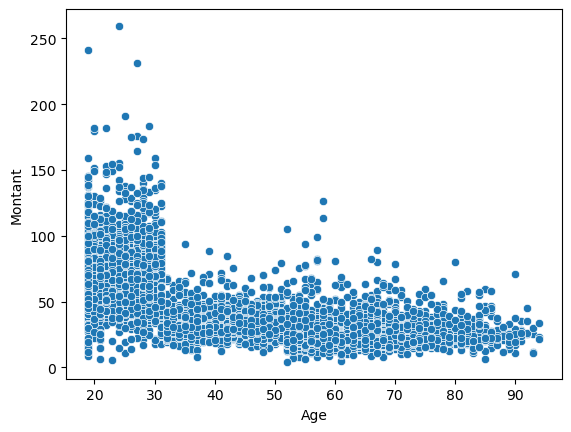

In [86]:
sns.scatterplot(data=panier_client_moy,x='age',y='price')
plt.xlabel("Age")
plt.ylabel("Montant")

### Calculer p-valeur

In [87]:
list1= panier_client_moy['age']
list2= panier_client_moy['price']

corr, p = spearmanr(list1, list2)
print('Spearman correlation: %.3f' % corr, 'p-valeur=',p)

Spearman correlation: -0.701 p-valeur= 0.0



Les intérpretations des résultats des tests de spearman :

Une valeur positive (maximum = +1) indique une variation simultanée dans le même sens, une valeur négative (minimum = -1) une variation simultanée en sens inverse.

Une valeur de 0 de 𝑟s indique qu’il n’y a pas de relation entre les variables. Plus la valeur de 𝑟s est proche de −1 ou 1, plus la corrélation est forte ; et plus elle est proche de 0, plus la corrélation est faible.

Ici, le coefficient de corrélation lui-même est de -0.701. Cela indique une relation négatif (depuis son nombre négatif). La corrélation est significative, puisque la valeur de p est bien inférieure au seuil habituel de 0,05. 

H0: le coefficeint de corrélation de Spearman est ègal à 0 -> aucune corrélation 

H1: le coéfficient de corrélation de Spearman est différent de 0 -> il y a une corrélation

On rejette H0 si p-valeur < 0.05

Il y a une correlation négative entre l'age et la taille du panier moyen

Lʼâge est corrélé au chiffre dʼaffaires au sens inverse

## <a name="C12">12. Le lien entre le genre d’un client et les catégories des livres achetés - Chi2</a> 

In [88]:
# Table de contingence
cont = pd.crosstab(trans_prod_cli['categ'], trans_prod_cli['sex'], margins=False)
print('Table de contingence :')
print(cont)

import researchpy as rp

# Table de contingence normalisée
table, results = rp.crosstab(trans_prod_cli['categ'], trans_prod_cli['sex'], prop='col', test='chi-square')
print('\n' + '-' * 55, '\n\nTable de contingence normalisée :')
print(table)

Table de contingence :
sex         f       m
categ                
0.0    206220  209460
1.0    114899  112270
2.0     17283   19200

------------------------------------------------------- 

Table de contingence normalisée :
          sex                
sex         f       m     All
categ                        
0.0     60.94   61.44   61.19
1.0     33.95   32.93   33.44
2.0      5.11    5.63    5.37
All    100.00  100.00  100.00


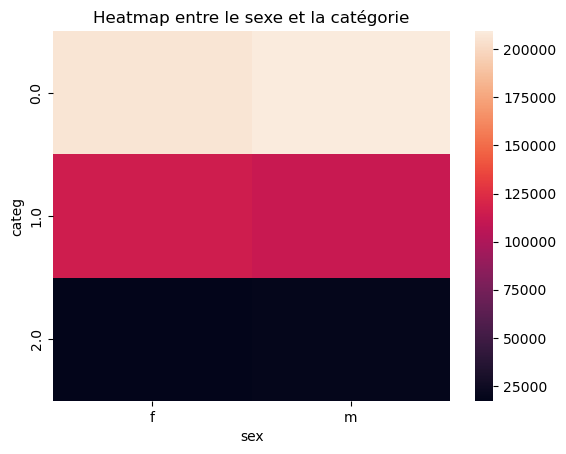

In [89]:
sns.heatmap(cont)
plt.title('Heatmap entre le sexe et la catégorie')
plt.savefig( 'heatmap_sexe-categorie.png', dpi=300, bbox_inches='tight')
plt.show()

Conditions

Le test de normalité ne fait pas partie des conditions du khi-deux, vu qu'on ne mesure pas la normalité que sur des variables quantitatives.

On doit malgré tout valider 2 conditions :

au moins 1 valeur dans chaque cellule de la table de contingence au moins 80% des valeurs égales ou supérieures à 0.05 Ces conditions étant remplies, la p-value confirme l'hypothèse 0, et l'absence corrélation entre les catégories et le sexe.

In [90]:
# Test de Chi 2

stat, p, dof, expected = stats.chi2_contingency(cont)
print('Test de Chi 2 (2 catégorielles)')
print('Stat = %.3f\np-value = %.35f' % (stat, p))
if p > .05:
    print('H0: les deux échantillons sont indépendants')
else:
    print('H1: il y a une dépendance entre les échantillons.')
print('\nConditions :\n'
      '- Les observations utilisées dans le calcul du tableau de contingence sont indépendantes.',
      '\n- 25 exemples ou plus dans chaque cellule du tableau de contingence.')

Test de Chi 2 (2 catégorielles)
Stat = 147.003
p-value = 0.00000000000000000000000000000001199
H1: il y a une dépendance entre les échantillons.

Conditions :
- Les observations utilisées dans le calcul du tableau de contingence sont indépendantes. 
- 25 exemples ou plus dans chaque cellule du tableau de contingence.
